# Tutorial for building fraction impacts as baseline for displacement post-processing

In this code, we apply the concept of displacement following a particular level of building damage post impact calculation. Meaning, we first calculate building fraction damages for each event and store the resulting impact matrices together with the exposure dataframe. On this basis, we can postprocess the results and convert thresholds of buildling-fraction damage to displaced population.

This approach stands in contrast to applying the building threshold prior to the impact calculation on the level of the impact functions.

Here, we explore this approach for the coastal flood hazard in 2 countries (PHL, SOM). We use two vulnerability function sources (CIMA/Capra and IVM). Additionally, we test the feasiblity of applying the same approach to event-based hazards (TC).

In [72]:
# Load country BEM as prep
from climada.util.constants import SYSTEM_DIR
from climada.hazard import TropCyclone, Hazard
from climada.entity.exposures import Exposures
from climada.engine import ImpactCalc
import numpy as np
import os
import copy
from pathlib import Path

os.chdir('/cluster/project/climate/meilers/scripts/displacement/global-displacement-risk') 
#os.chdir('/cluster/project/climate/evelynm/global-displacement-risk') 
import exposure
import vulnerability
import coastal_flood_hazard
import impact_postproc

# select country here
cntry = 'Somalia'

In [73]:
# load bem
gdf_bem_subcomps = exposure.gdf_from_bem_subcomps(cntry, opt='full')
gdf_bem_subcomps = gdf_bem_subcomps[gdf_bem_subcomps.valhum>1] # filter out rows with basically no population

In [74]:
# assign admin-1
gdf_bem_subcomps = exposure.assign_admin1_attr(gdf_bem_subcomps, exposure.path_admin1_attrs, source='gadm')

In [75]:
# make exposure
exp = Exposures(gdf_bem_subcomps.copy())
exp.value_unit = 'Pop. count'
exp.gdf['longitude'] = exp.gdf.geometry.x
exp.gdf['latitude'] = exp.gdf.geometry.y
exp.gdf['value'] = 1 # each building type gets value 1

## FL impacts

### Base Scenario

In [5]:
exp.gdf['impf_FL_cima'] = exp.gdf['se_seismo'].map(vulnerability.DICT_PAGER_FLIMPF_CIMA)

In [6]:
exp.gdf['impf_FL_ivm'] = exp.gdf['se_seismo'].map(vulnerability.DICT_PAGER_FLIMPF_IVM)

In [52]:
exp.gdf.head()

,id_1x,iso3,cpx,sector,se_seismo,valhum,valfis,bd_1_floor,bd_2_floor,bd_3_floor,geometry,admin1,longitude,latitude,value,impf_FL,impf_FL_ivm,centr_FL
0,194457751,SOM,3,edu_pub,W2,3.642231,0.011027,0.0,0.0,0.0,POINT (43.40417 0.66250),2844.0,43.404167,0.6625,1,2,2,125004
1,194457751,SOM,3,edu_pub,W1,1.557365,0.004715,0.0,0.0,0.0,POINT (43.40417 0.66250),2844.0,43.404167,0.6625,1,2,2,125004
2,194457751,SOM,3,ic_low,W2,15.383508,0.004852,0.0,0.0,0.0,POINT (43.40417 0.66250),2844.0,43.404167,0.6625,1,2,2,125004
3,194457751,SOM,3,ic_low,W1,6.577763,0.002074,0.0,0.0,0.0,POINT (43.40417 0.66250),2844.0,43.404167,0.6625,1,2,2,125004
4,194457751,SOM,3,ic_low,RS2,1.697488,0.000535,0.0,0.0,0.0,POINT (43.40417 0.66250),2844.0,43.404167,0.6625,1,3,3,125004


### Flood CIMA

In [5]:
HAZ_FOLDER = Path(f'/cluster/work/climate/evelynm/IDMC_UNU/hazard/flood_HM_CIMA/{cntry}/HISTORICAL/')
HAZ_TYPE = 'FL'

haz_files = np.sort([str(file) for file in HAZ_FOLDER.glob('*.tif')])
rp = np.sort(np.array([int(Path(file).stem[-4:]) for file in haz_files]))

In [6]:
# Create the Hazard object
haz = Hazard.from_raster(
    haz_type=HAZ_TYPE,
    files_intensity=list(haz_files),
    src_crs='WGS84',
    attrs={
        'unit': 'm',
        'event_id': np.arange(len(haz_files)),
        'frequency': 1 / rp
    }
)
haz.intensity = haz.intensity/100

In [ ]:
haz.plot_intensity(event=0)

In [9]:
exp.gdf.rename({'impf_FL_cima' : 'impf_FL'}, axis=1, inplace=True)
imp_cima = ImpactCalc(exp, vulnerability.IMPF_SET_FL_CIMA, haz).impact(save_mat=True)

In [10]:
imp_cima.imp_mat

<9x1439740 sparse matrix of type '<class 'numpy.float64'>'
	with 943524 stored elements in Compressed Sparse Row format>

### Coastal flood

In [5]:
# from scratch:
haz_CF_dir = Path('/cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km')

# get tiles covering the exposure extent
tiles = coastal_flood_hazard.find_tiles(
    exp.gdf['latitude'].min(), exp.gdf['latitude'].max(), exp.gdf['longitude'].min(), exp.gdf['longitude'].max())

# load CF hazard 
CF = coastal_flood_hazard.generate_hazard_object(tiles, haz_CF_dir, 'RCP45', '2020', 'FL')

Tile directory /cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km/S02E043/RCP45_2020 not found, skipping...
Tile directory /cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km/S02E044/RCP45_2020 not found, skipping...
Tile directory /cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km/S02E045/RCP45_2020 not found, skipping...
Tile directory /cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km/S02E046/RCP45_2020 not found, skipping...
Tile directory /cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km/S02E047/RCP45_2020 not found, skipping...
Tile directory /cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km/S02E048/RCP45_2020 not found, skipping...
Tile directory /cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km/S02E049/RCP45_2020 not found, skipping...
Tile directory /cluster/work/climate/evelynm/IDMC_UNU/h

In [6]:
# Few checks:
print(CF.frequency)
print(CF.event_id)

[1.    0.1   0.04  0.02  0.01  0.004 0.001 1.    0.1   0.04  0.02  0.01
 0.004 0.001 1.    0.1   0.04  0.02  0.01  0.004 0.001 1.    0.1   0.04
 0.02  0.01  0.004 0.001 1.    0.1   0.04  0.02  0.01  0.004 0.001 1.
 0.1   0.04  0.02  0.01  0.004 0.001 1.    0.1   0.04  0.02  0.01  0.004
 0.001 1.    0.1   0.04  0.02  0.01  0.004 0.001 1.    0.1   0.04  0.02
 0.01  0.004 0.001 1.    0.1   0.04  0.02  0.01  0.004 0.001 1.    0.1
 0.04  0.02  0.01  0.004 0.001 1.    0.1   0.04  0.02  0.01  0.004 0.001
 1.    0.1   0.04  0.02  0.01  0.004 0.001 1.    0.1   0.04  0.02  0.01
 0.004 0.001 1.    0.1   0.04  0.02  0.01  0.004 0.001 1.    0.1   0.04
 0.02  0.01  0.004 0.001 1.    0.1   0.04  0.02  0.01  0.004 0.001 1.
 0.1   0.04  0.02  0.01  0.004 0.001 1.    0.1   0.04  0.02  0.01  0.004
 0.001 1.    0.1   0.04  0.02  0.01  0.004 0.001 1.    0.1   0.04  0.02
 0.01  0.004 0.001 1.    0.1   0.04  0.02  0.01  0.004 0.001 1.    0.1
 0.04  0.02  0.01  0.004 0.001 1.    0.1   0.04  0.02  0.01  0.004 

<GeoAxesSubplot: title={'center': 'FL max intensity at each point'}>

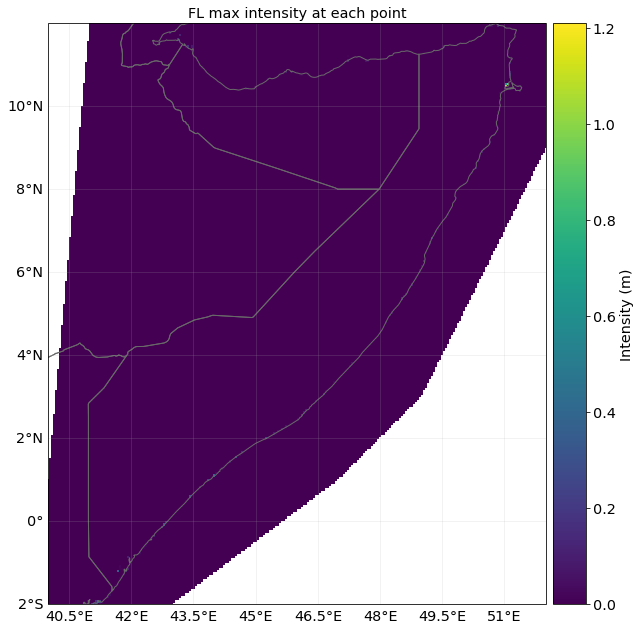

In [9]:
CF.plot_intensity(0)

In [12]:
# other option: load directly from pre-computed hazard files
dir_precomp_haz = Path('/cluster/work/climate/evelynm/IDMC_UNU/hazard/processed/')
CF = Hazard.from_hdf5(dir_precomp_haz+f'{cntry}_CF.hdf5')

In [8]:
# compute damage fractions on buildings; keep "events", i.e. in case of flood RPs individually
# use two impact function sets (2 scenarios)

# scenario 1: capra/cima impfs
exp.gdf['impf_FL'] = exp.gdf['se_seismo'].map(vulnerability.DICT_PAGER_FLIMPF_CIMA)
impact_bldg_cima = ImpactCalc(exp, vulnerability.IMPF_SET_FL_CIMA, CF).impact(save_mat=True)

2024-05-17 14:39:33,853 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 1868 coordinates.


In [9]:
# scenario 2: ivm impfs
exp.gdf['impf_FL'] = exp.gdf['se_seismo'].map(vulnerability.DICT_PAGER_FLIMPF_IVM)
impact_bldg_ivm = ImpactCalc(exp, vulnerability.IMPF_SET_FL_IVM, CF).impact(save_mat=True)

2024-05-17 14:39:35,644 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 1868 coordinates.


In [76]:
# set displacement-damage threshold(s) - 3 more scenarios each
dmg_thresh_low = 0.35
dmg_thresh_med = 0.55
dmg_thresh_high = 0.65

In [11]:
# do a few sanity checks
print('max dmg cima:', impact_bldg_cima.imp_mat.data.max(), 'min dmg cima:', impact_bldg_cima.imp_mat.data.min())
print('max dmg ivm:', impact_bldg_ivm.imp_mat.data.max(), 'min dmg ivm:', impact_bldg_ivm.imp_mat.data.min())

max dmg cima: 0.2987988462249438 min dmg cima: 4.7578947685557596e-08
max dmg ivm: 0.9046648263931275 min dmg ivm: 6.4279158323188306e-06


In [12]:
# decide on whether threshold reached for all 2*3 scenarios
displ_low_cima = impact_bldg_cima.imp_mat > dmg_thresh_low
displ_med_cima = impact_bldg_cima.imp_mat > dmg_thresh_med
displ_high_cima = impact_bldg_cima.imp_mat > dmg_thresh_high

displ_low_ivm = impact_bldg_ivm.imp_mat > dmg_thresh_low
displ_med_ivm = impact_bldg_ivm.imp_mat > dmg_thresh_med
displ_high_ivm = impact_bldg_ivm.imp_mat > dmg_thresh_high

In [ ]:
# Particular to CF: needs post-processing of many "events" (# of tiles * 7 RPs) into 7 RP "events" 
# --> sum every 7th column (requires blowing up sparse matrix)
# shown here now step by step for one scenario (cima - low) - turned into a function below.

In [13]:
rps = 1/CF.frequency[:7]

In [14]:
displ_full = displ_low_cima.toarray()

In [15]:
# get indices to sum over for each of the 7 RPs(rows)
ix_rps = {}
for ix, rp in enumerate(rps):
    ix_rps[rp] = np.arange(0+ix,displ_full.shape[0],7)

In [16]:
# save (Human displacemment!) impacts to exposure gdf
for rp in rps:
    exp.gdf[f'imp_rp_{rp}'] = displ_full[ix_rps[rp],:].astype(int).sum(axis=0)*exp.gdf['valhum']

In [28]:
PATH_RESULTS = Path('/cluster/work/climate/evelynm/IDMC_UNU/results/risk_cf')
PATH_RESULTS / cntry

PosixPath('/cluster/work/climate/evelynm/IDMC_UNU/results/risk_cf/Somalia')

In [21]:
# groupe exposure gdf by admin1 and sum over impacts (keep only these)
imps_admin1 = exp.gdf.groupby('admin1').sum()[[f'imp_rp_{rp}' for rp in rps]]

In [22]:
# from this we can now manually compute the AED
imps_admin1['aed'] = 0
for rp in rps:
    imps_admin1['aed']+= imps_admin1[f'imp_rp_{rp}']/rp 

In [26]:
# compute admin0 imps
imps_admin_0 = imps_admin1.sum(axis=0)
imps_admin_0.name = 'admin0'
imps_admin1.append(imps_admin_0)

,imp_rp_1.0,imp_rp_10.0,imp_rp_25.0,imp_rp_50.0,imp_rp_100.0,imp_rp_250.0,imp_rp_1000.0,aed
admin1,,,,,,,,
925.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2836.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2837.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2838.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2839.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2840.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2841.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2842.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
imps_admin_0

admin1
925.0     0.0
1500.0    0.0
2836.0    0.0
2837.0    0.0
2838.0    0.0
2839.0    0.0
2840.0    0.0
2841.0    0.0
2842.0    0.0
2843.0    0.0
2844.0    0.0
2845.0    0.0
2846.0    0.0
2847.0    0.0
2848.0    0.0
2849.0    0.0
2850.0    0.0
2851.0    0.0
2852.0    0.0
2853.0    0.0
Name: admin0, dtype: float64

In [20]:
imps_admin1

,imp_rp_1.0,imp_rp_10.0,imp_rp_25.0,imp_rp_50.0,imp_rp_100.0,imp_rp_250.0,imp_rp_1000.0,aed
admin1,,,,,,,,
925.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2836.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2837.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2838.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2839.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2840.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2841.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2842.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
def agg_sparse_rps(sparse_bool, exp_gdf, rps, scen_name, group_admin1=True):
    """
    Aggregate a sparse boolean impact matrix (displacement True/False) obtained from various tiles and RP maps
    into the full exposure format per RP.
    
    Parameters
    -----------
    sparse_bool: sparse.csr_matrix
        imp_mat with types bool (contrasted against dmg threshold)
    rps : np.array 
        unique return periods to group by (1/frequ of hazard events)
    exp_gdf : gpd.GeoDataFrame
        exposure geodataframe to append impacts to
    scen_name : str 
        scenario name to differentiate various impact matrices by(suggestion {impfsource}_{thresh})
    group_admin1 : bool
        whether to group results by admin1 (default: True), else full exp_gdf returned
        
    Returns
    -------
    DataFrame with columns imp_{rps}_{scen_name}, either full exposure or grouped by admin1
    """
    full_bool = sparse_bool.toarray()
    
    # get indices to sum over for each of the 7 RPs(rows)
    ix_rps = {}
    for ix, rp in enumerate(rps):
        ix_rps[rp] = np.arange(0+ix,full_bool.shape[0],7)
    
    # save impacts to exposure gdf
    for rp in rps:
        exp_gdf[f'imp_rp_{rp}_{scen_name}'] = full_bool[ix_rps[rp],:].astype(int).sum(axis=0)*exp_gdf['valhum']
    
    # groupe exposure gdf by admin1 and sum over impacts (keep only these)
    if group_admin1:
        return exp_gdf.groupby('admin1').sum()[[f'imp_rp_{rp}_{scen_name}' for rp in rps]]
    
    return exp_gdf[[f'imp_rp_{rp}_{scen_name}' for rp in rps]]

In [30]:
def compute_aeds(df_imps, rps, scen_name):
    """
    Manually compute average anually expected displacement, as 
    sum(displacement(rpx)/(rpx)) forall rpx
    
    Parameters
    ----------
    df_imps, 
    rps, 
    scen_name
    
    
    Returns
    --------
    df_imps with additional column aed
    """
    df_imps[f'aed_{scen_name}'] = 0
    for rp in rps:
        df_imps[f'aed_{scen_name}']+= df_imps[f'imp_rp_{rp}_{scen_name}']/rp 
    return df_imps

In [31]:
# show for a few examples:

In [32]:
imp_cima_low = agg_sparse_rps(displ_low_cima, exp.gdf, rps, 'cima_low', group_admin1=True)
imp_cima_low = compute_aeds(imp_cima_low, rps, 'cima_low')
imp_cima_low

,imp_rp_1.0_cima_low,imp_rp_10.0_cima_low,imp_rp_25.0_cima_low,imp_rp_50.0_cima_low,imp_rp_100.0_cima_low,imp_rp_250.0_cima_low,imp_rp_1000.0_cima_low,aed_cima_low
admin1,,,,,,,,
925.0,0,0,0,0,0,0,0,0.0
1500.0,0,0,0,0,0,0,0,0.0
2836.0,0,0,0,0,0,0,0,0.0
2837.0,0,0,0,0,0,0,0,0.0
2838.0,0,0,0,0,0,0,0,0.0
2839.0,0,0,0,0,0,0,0,0.0
2840.0,0,0,0,0,0,0,0,0.0
2841.0,0,0,0,0,0,0,0,0.0
2842.0,0,0,0,0,0,0,0,0.0


In [33]:
imp_ivm_low = agg_sparse_rps(displ_low_ivm, exp.gdf, rps, 'ivm_low', group_admin1=True)
imp_ivm_low = compute_aeds(imp_ivm_low, rps, 'ivm_low')
imp_ivm_low

,imp_rp_1.0_ivm_low,imp_rp_10.0_ivm_low,imp_rp_25.0_ivm_low,imp_rp_50.0_ivm_low,imp_rp_100.0_ivm_low,imp_rp_250.0_ivm_low,imp_rp_1000.0_ivm_low,aed_ivm_low
admin1,,,,,,,,
925.0,0,0,0,0,0,0,0,0.000
1500.0,0,0,0,0,0,0,0,0.000
2836.0,0,0,0,0,0,0,0,0.000
2837.0,0,0,0,0,0,0,0,0.000
2838.0,25,25,25,25,25,51,51,29.505
2839.0,0,0,0,0,0,0,0,0.000
2840.0,0,0,0,0,0,0,0,0.000
2841.0,0,0,0,0,0,0,0,0.000
2842.0,0,0,0,0,0,0,0,0.000


In [34]:
imp_ivm_high = agg_sparse_rps(displ_high_ivm, exp.gdf, rps, 'ivm_high', group_admin1=True)
imp_ivm_high = compute_aeds(imp_ivm_high, rps, 'ivm_high')
imp_ivm_high

,imp_rp_1.0_ivm_high,imp_rp_10.0_ivm_high,imp_rp_25.0_ivm_high,imp_rp_50.0_ivm_high,imp_rp_100.0_ivm_high,imp_rp_250.0_ivm_high,imp_rp_1000.0_ivm_high,aed_ivm_high
admin1,,,,,,,,
925.0,0,0,0,0,0,0,0,0.000
1500.0,0,0,0,0,0,0,0,0.000
2836.0,0,0,0,0,0,0,0,0.000
2837.0,0,0,0,0,0,0,0,0.000
2838.0,0,0,0,0,0,0,0,0.000
2839.0,0,0,0,0,0,0,0,0.000
2840.0,0,0,0,0,0,0,0,0.000
2841.0,0,0,0,0,0,0,0,0.000
2842.0,0,0,0,0,0,0,0,0.000


In [35]:
# compute for all remaining ones (make dicts out of all these):
imp_cima_med = agg_sparse_rps(displ_med_cima, exp.gdf, rps, 'cima_med', group_admin1=True)
imp_cima_med = compute_aeds(imp_cima_med, rps, 'cima_med')

imp_cima_high = agg_sparse_rps(displ_high_cima, exp.gdf, rps, 'cima_high', group_admin1=True)
imp_cima_high = compute_aeds(imp_cima_high, rps, 'cima_high')

imp_ivm_med = agg_sparse_rps(displ_med_ivm, exp.gdf, rps, 'ivm_med', group_admin1=True)
imp_ivm_med = compute_aeds(imp_ivm_med, rps, 'ivm_med')

In [36]:
# group all scenarios and get median, min, max

In [37]:
import pandas as pd
imp_all_scens = pd.concat([imp_cima_low, imp_cima_med, imp_cima_high, imp_ivm_low, imp_ivm_med, imp_ivm_high], axis=1
                         )
imp_all_scens

,imp_rp_1.0_cima_low,imp_rp_10.0_cima_low,imp_rp_25.0_cima_low,imp_rp_50.0_cima_low,imp_rp_100.0_cima_low,imp_rp_250.0_cima_low,imp_rp_1000.0_cima_low,aed_cima_low,imp_rp_1.0_cima_med,imp_rp_10.0_cima_med,...,imp_rp_1000.0_ivm_med,aed_ivm_med,imp_rp_1.0_ivm_high,imp_rp_10.0_ivm_high,imp_rp_25.0_ivm_high,imp_rp_50.0_ivm_high,imp_rp_100.0_ivm_high,imp_rp_250.0_ivm_high,imp_rp_1000.0_ivm_high,aed_ivm_high
admin1,,,,,,,,,,,,,,,,,,,,,
925.0,0,0,0,0,0,0,0,0.0,0,0,...,0,0.000,0,0,0,0,0,0,0,0.000
1500.0,0,0,0,0,0,0,0,0.0,0,0,...,0,0.000,0,0,0,0,0,0,0,0.000
2836.0,0,0,0,0,0,0,0,0.0,0,0,...,0,0.000,0,0,0,0,0,0,0,0.000
2837.0,0,0,0,0,0,0,0,0.0,0,0,...,0,0.000,0,0,0,0,0,0,0,0.000
2838.0,0,0,0,0,0,0,0,0.0,0,0,...,0,0.000,0,0,0,0,0,0,0,0.000
2839.0,0,0,0,0,0,0,0,0.0,0,0,...,0,0.000,0,0,0,0,0,0,0,0.000
2840.0,0,0,0,0,0,0,0,0.0,0,0,...,0,0.000,0,0,0,0,0,0,0,0.000
2841.0,0,0,0,0,0,0,0,0.0,0,0,...,0,0.000,0,0,0,0,0,0,0,0.000
2842.0,0,0,0,0,0,0,0,0.0,0,0,...,0,0.000,0,0,0,0,0,0,0,0.000


In [38]:
imp_stats = pd.DataFrame()

for rp in rps:
    imp_stats[f'rp_{rp}_min'] = np.min(imp_all_scens[[col for col in imp_all_scens.columns if str(rp) in col ]], axis=1)
    imp_stats[f'rp_{rp}_med'] = np.median(imp_all_scens[[col for col in imp_all_scens.columns if str(rp) in col ]], axis=1)
    imp_stats[f'rp_{rp}_max'] = np.min(imp_all_scens[[col for col in imp_all_scens.columns if str(rp) in col ]], axis=1)
imp_stats[f'aed_min'] = np.min(imp_all_scens[[col for col in imp_all_scens.columns if 'aed' in col ]], axis=1)
imp_stats[f'aed_med'] = np.median(imp_all_scens[[col for col in imp_all_scens.columns if 'aed' in col ]], axis=1)
imp_stats[f'aed_max'] = np.max(imp_all_scens[[col for col in imp_all_scens.columns if 'aed' in col ]], axis=1)
imp_stats

,rp_1.0_min,rp_1.0_med,rp_1.0_max,rp_10.0_min,rp_10.0_med,rp_10.0_max,rp_25.0_min,rp_25.0_med,rp_25.0_max,rp_50.0_min,...,rp_100.0_max,rp_250.0_min,rp_250.0_med,rp_250.0_max,rp_1000.0_min,rp_1000.0_med,rp_1000.0_max,aed_min,aed_med,aed_max
admin1,,,,,,,,,,,,,,,,,,,,,
925.0,0,0.0,0,0,0.0,0,0,0.0,0,0,...,0,0,0.0,0,0,0.0,0,0.0,0.0000,0.000
1500.0,0,0.0,0,0,0.0,0,0,0.0,0,0,...,0,0,0.0,0,0,0.0,0,0.0,0.0000,0.000
2836.0,0,0.0,0,0,0.0,0,0,0.0,0,0,...,0,0,0.0,0,0,0.0,0,0.0,0.0000,0.000
2837.0,0,0.0,0,0,0.0,0,0,0.0,0,0,...,0,0,0.0,0,0,0.0,0,0.0,0.0000,0.000
2838.0,0,0.0,0,0,0.0,0,0,0.0,0,0,...,0,0,0.0,0,0,0.0,0,0.0,0.0000,29.505
2839.0,0,0.0,0,0,0.0,0,0,0.0,0,0,...,0,0,0.0,0,0,0.0,0,0.0,0.0000,0.000
2840.0,0,0.0,0,0,0.0,0,0,0.0,0,0,...,0,0,0.0,0,0,0.0,0,0.0,0.0000,0.000
2841.0,0,0.0,0,0,0.0,0,0,0.0,0,0,...,0,0,0.0,0,0,0.0,0,0.0,0.0000,0.000
2842.0,0,0.0,0,0,0.0,0,0,0.0,0,0,...,0,0,0.0,0,0,0.0,0,0.0,0.0000,0.000


In [40]:
imp_stats[[col for col in imp_stats.columns if 'aed' in col]].sum()

aed_min      0.000
aed_med      9.995
aed_max    302.455
dtype: float64

In [ ]:
# Question: what to save? 

# sparse imp_mats (bldg frac dmg) for further postprocessing 
# all-scenarios-admin1-df
# stats-df
# write country-aed to dict 

In [ ]:
# TODO next: write one pipeline that accepts only iso3 code (for running in batches on cluster)
# --> ~/displacement_risk_coastalflood.py

## TC impact functions

### Base scenario

In [77]:
exp.gdf['impf_TC_base'] = exp.gdf['se_seismo'].map(vulnerability.DICT_PAGER_TCIMPF_HAZUS)

### Min, med, max scenarios

Skip these scenarios for now

In [9]:
# we modify the dictionary to point to the "_min", "_med" and "_max" vulnerability functions everywhere 
DICT_TCIMPF_MIN = {key: vulnerability.DICT_HAZUS_IMPF_TC_HAZUS[value[:-3]+'min']
                           for key, value in vulnerability.DICT_PAGER2HAZUS.items()}
DICT_TCIMPF_MED = {key: vulnerability.DICT_HAZUS_IMPF_TC_HAZUS[value[:-3]+'med']
                           for key, value in vulnerability.DICT_PAGER2HAZUS.items()}
DICT_TCIMPF_MAX = {key: vulnerability.DICT_HAZUS_IMPF_TC_HAZUS[value[:-3]+'max']
                           for key, value in vulnerability.DICT_PAGER2HAZUS.items()}

In [10]:
exp.gdf['impf_TC_min'] = exp.gdf['se_seismo'].map(DICT_TCIMPF_MIN) 

In [11]:
exp.gdf['impf_TC_med'] = exp.gdf['se_seismo'].map(DICT_TCIMPF_MED) 

In [12]:
exp.gdf['impf_TC_max'] = exp.gdf['se_seismo'].map(DICT_TCIMPF_MAX) 

### Perform impact calcs and compare

In [78]:
# load TC hazard phl
if cntry == 'Somalia':
    reg = 'IO'
elif cntry == 'Philippines':
    reg = 'WP'
else:
    reg = print('no country-basin assingment found')

haz_TC_dir = Path('/cluster/work/climate/meilers/climada/data/hazard/present')
haz_TC = TropCyclone.from_hdf5(haz_TC_dir.joinpath(f'TC_{reg}_0150as_MIT_H08.hdf5'))

In [79]:
TC = haz_TC.select(extent=(
    exp.gdf['longitude'].min(), exp.gdf['longitude'].max(), exp.gdf['latitude'].min(), exp.gdf['latitude'].max()))

In [80]:
TC.frequency

array([0.00013566, 0.00013566, 0.00013566, ..., 0.00018377, 0.00018377,
       0.00018377])

In [113]:
exp.gdf.rename({'impf_TC_base' : 'impf_TC'}, axis=1, inplace=True)

imp_base = ImpactCalc(exp, vulnerability.IMPF_SET_TC_HAZUS, TC).impact(save_mat=True)

In [114]:
print('max dmg:', imp_base.imp_mat.data.max(), 'min dmg:', imp_base.imp_mat.data.min())

max dmg: 0.9854068940003684 min dmg: 2.355996527100066e-10


In [115]:
displ_low_TC = imp_base.imp_mat > dmg_thresh_low
displ_med_TC = imp_base.imp_mat > dmg_thresh_med
displ_high_TC = imp_base.imp_mat > dmg_thresh_high

**Idea: calculate the aai_agg from the impact matrix using the CLIMADA logic of aai_agg = sum(impact.at_event x frequency)**

i) create diagonal matrix from TC.frequency vector  
ii) multiply boolean impact matrix with it  
iii) sum remaining entries up  

In [120]:
from scipy.sparse import csr_matrix

freq_diagonal_matrix = csr_matrix(np.diag(TC.frequency))

In [141]:
imp_bldg_frac = freq_diagonal_matrix @ displ_low_TC

In [142]:
imp_bldg_frac

<20500x522899 sparse matrix of type '<class 'numpy.float64'>'
	with 184069 stored elements in Compressed Sparse Row format>

In [143]:
print('max dmg:', imp_bldg_frac.data.max(), 'min dmg:', imp_bldg_frac.data.min())

max dmg: 0.0002872184 min dmg: 7.494999024390244e-05


In [144]:
imp_bldg_frac.sum()

38.57049972625205

**Next: convert building fraction damage to displaced population**

i) multiply building fraction impact matrix (imp_bldg_frac) with the exposure gdf "valhum" value   
ii) sum up for population aai_agg 

In [145]:
imp_pop = sum(imp_bldg_frac * exp.gdf.valhum)

In [146]:
imp_pop

582.8160325389964

**how does this compare to the application of a step function at a particular threshold (here dmg_thresh_med) and default impact.aai_agg method?**

i) make step function  
ii) perform trivial impact calculation (no save_mat)  
iii) get aai_agg  

In [147]:
impf_set_tc = vulnerability.IMPF_SET_TC_HAZUS

from climada.entity import ImpactFunc, ImpactFuncSet
impf_set_tc_step = ImpactFuncSet()

# The threshold of building damage after which all people are displaced. Below, no-one is displaced.
building_thresh = dmg_thresh_low # 55% iDMC v1; CIMA: 30% for Somalia to 60% for other countries. 

for imp_id in impf_set_tc.get_ids(haz_type='TC'):
    impf_set_tc.get_func(fun_id=imp_id)
    y = impf_set_tc.get_func(fun_id=imp_id)[0].intensity
    x = impf_set_tc.get_func(fun_id=imp_id)[0].mdd
    thresh = np.interp(building_thresh, x, y)
    print('ID: '+str(imp_id)+' - threshold stepfunction: '+str(thresh))
    impf_set_tc_step.append(
                ImpactFunc.from_step_impf(
                    intensity=(0,  thresh, thresh *10),
                    haz_type='TC',
                    impf_id=imp_id,
                    intensity_unit = 'm/s'
                )
    )

ID: 1 - threshold stepfunction: 64.17422312942928
ID: 2 - threshold stepfunction: 86.82377045005418
ID: 3 - threshold stepfunction: 109.22161705344672
ID: 4 - threshold stepfunction: 56.62684745716406
ID: 5 - threshold stepfunction: 75.49759162652632
ID: 6 - threshold stepfunction: 94.37296325662898
ID: 7 - threshold stepfunction: 66.60883656499395
ID: 8 - threshold stepfunction: 98.1468920687258
ID: 9 - threshold stepfunction: 109.22161705344672
ID: 10 - threshold stepfunction: 57.96424194268826
ID: 11 - threshold stepfunction: 66.60883656499395
ID: 12 - threshold stepfunction: 83.04859676585143
ID: 13 - threshold stepfunction: 39.09340681565368
ID: 14 - threshold stepfunction: 85.48055762032364
ID: 15 - threshold stepfunction: 66.60883656499395


In [148]:
imp_base_step = ImpactCalc(exp, impf_set_tc_step, TC).impact()

In [149]:
imp_base_step.aai_agg

38.57049972624391

**Compute aai_agg for population value (not building fraction)**

In [150]:
exp.gdf.rename({'value': 'valfrac'}, axis=1, inplace=True)

In [151]:
exp.gdf.rename({'valhum': 'value'}, axis=1, inplace=True)

In [156]:
exp.gdf.rename({'value': 'valhum'}, axis=1, inplace=True)

In [157]:
exp.gdf.rename({'valfrac': 'value'}, axis=1, inplace=True)

In [158]:
exp.gdf.head()

,id_1x,iso3,cpx,sector,se_seismo,valhum,valfis,bd_1_floor,bd_2_floor,bd_3_floor,geometry,admin1,longitude,latitude,value,impf_TC,centr_TC
0,194457751,SOM,3,edu_pub,W2,3.642231,0.011027,0.0,0.0,0.0,POINT (43.40417 0.66250),2844.0,43.404167,0.6625,1,12,46963
1,194457751,SOM,3,edu_pub,W1,1.557365,0.004715,0.0,0.0,0.0,POINT (43.40417 0.66250),2844.0,43.404167,0.6625,1,10,46963
2,194457751,SOM,3,ic_low,W2,15.383508,0.004852,0.0,0.0,0.0,POINT (43.40417 0.66250),2844.0,43.404167,0.6625,1,12,46963
3,194457751,SOM,3,ic_low,W1,6.577763,0.002074,0.0,0.0,0.0,POINT (43.40417 0.66250),2844.0,43.404167,0.6625,1,10,46963
4,194457751,SOM,3,ic_low,RS2,1.697488,0.000535,0.0,0.0,0.0,POINT (43.40417 0.66250),2844.0,43.404167,0.6625,1,4,46963


In [153]:
imp_pop_step = ImpactCalc(exp, impf_set_tc_step, TC).impact()

In [154]:
imp_pop_step.aai_agg

582.8160325389965

#### Plot results

In [104]:
import copy as cp
imp_bldg_frac_plot = cp.deepcopy(imp_base)
imp_bldg_frac_plot.imp_mat = imp_freq_adjusted.data

##### Building fraction - impact matrix

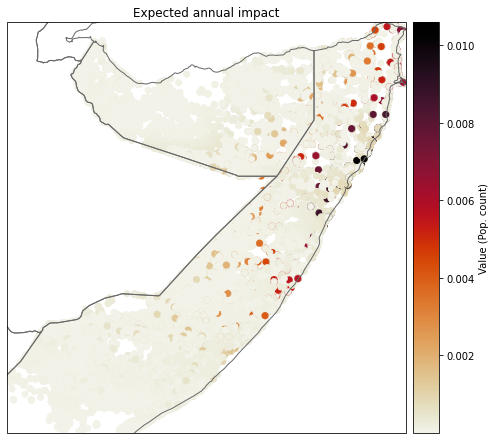

In [105]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = plt.subplots(figsize=(9, 6), subplot_kw={'projection': ccrs.PlateCarree()})

imp_bldg_frac_plot.plot_scatter_eai_exposure(
    ignore_zero=True,
    pop_name=False,
    axis=ax
)

plt.show()

##### Building fraction - step function w/ threshold

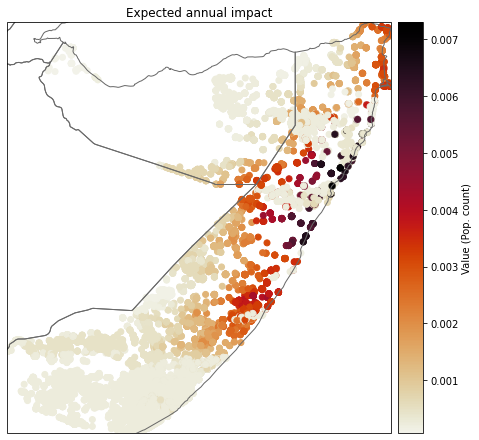

In [106]:
fig, ax = plt.subplots(figsize=(9, 6), subplot_kw={'projection': ccrs.PlateCarree()})

imp_base_step.plot_scatter_eai_exposure(
    ignore_zero=True,
    pop_name=False,
    axis=ax
)

plt.show()

##### Population displaced - impact matrix

In [136]:
imp_pop_plot = cp.deepcopy(imp_base)
imp_pop_plot.imp_mat = imp_pop.data

##### Population displaced - step function w/ threshold

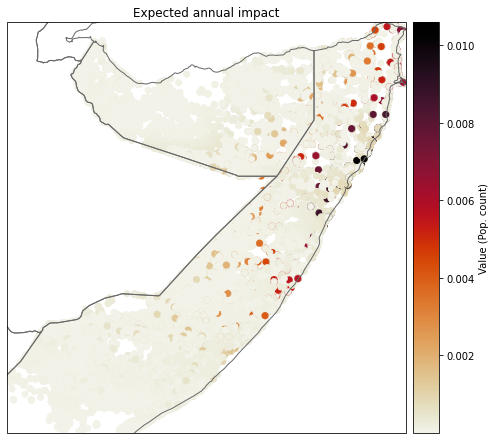

In [137]:
fig, ax = plt.subplots(figsize=(9, 6), subplot_kw={'projection': ccrs.PlateCarree()})

imp_pop_plot.plot_scatter_eai_exposure(
    ignore_zero=True,
    pop_name=False,
    axis=ax
)

plt.show()

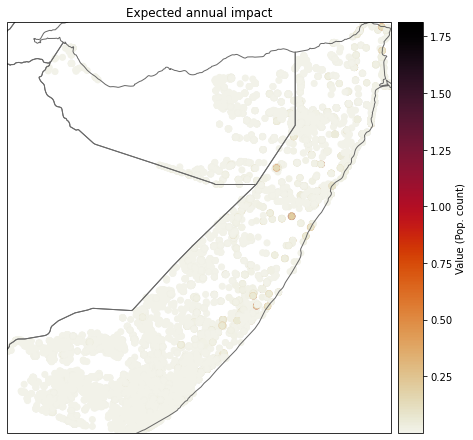

In [138]:
fig, ax = plt.subplots(figsize=(9, 6), subplot_kw={'projection': ccrs.PlateCarree()})

imp_pop_step.plot_scatter_eai_exposure(
    ignore_zero=True,
    pop_name=False,
    axis=ax
)

plt.show()

#### Questions and to dos for TC-related computations

**Questions:**  
* How can we calculate return period values from impact matrix?  
* How to deal with the various thresholds, levels of impact function granulatrity, multiple future climate scenarios

**to do:**  
* admin1 integration
* check if computations are correct